In [1]:
import torch
import torch.nn as nn
import math
import os
import json
import imageio
import numpy as np
import random
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt

In [2]:
def load_synthetic_images_and_camera_metadata(class_dir, num_classes=8):
    """
    Function: load_images_and_camera_metadata
    ----------------------------------------
    load images, poses, and camera angle information from the synthetic dataset,
    and select a specific number of classes.

    Parameters:
    - data_dir: Root directory of the synthetic dataset (containing multiple subdirectories or "classes").
    - num_classes: Number of classes to load from the dataset (default: 1).

    Returns:
    - images: Tensor of shape [N, H, W, 3]
    - poses: Tensor of shape [N, 4, 4]
    - camera_angle_x_list: List of floats, one per class, representing the field of view in the x-direction.
    """

    json_path = os.path.join(class_dir, 'transforms_train.json')
    with open(json_path, 'r') as f:
        data = json.load(f)

    images, poses = [], []
    for f in data['frames']:
        # f['file_path'] is already something like "train/r_0"
        img_file = os.path.join(class_dir, f['file_path'] + '.png')
        raw = imageio.v2.imread(img_file)
        if raw.ndim == 3 and raw.shape[2] == 4:
            raw = raw[..., :3]
        elif raw.ndim == 2:
            # (unlikely for this dataset) replicate gray→RGB
            raw = np.stack([raw, raw, raw], axis=-1)
        img = raw.astype(np.float32) / 255.0
        images.append(img)
        poses .append(np.array(f['transform_matrix'], dtype=np.float32))

    images = torch.tensor(np.stack(images), dtype=torch.float32)
    poses  = torch.tensor(np.stack(poses),  dtype=torch.float32)
    cam_ang = float(data['camera_angle_x'])
    N, H, W, _ = images.shape
    print(f"images: {images.shape}, poses: {poses.shape}, focal: {cam_ang:.4f}")

    # 3) pick device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("using device:", device)

    # 4) grab one example for visualization / test
    # test_img   = images[101]    # shape [H, W, 3]
    # test_pose  = poses[101]     # shape [4, 4]

    # 5) optionally subset your training set
    test_idx = min(101, N-1)    # if N<102, this gives N-1
    test_img, test_pose = images[test_idx], poses[test_idx]
    test_img  = test_img.to(device)
    test_pose = test_pose.to(device)

    # 6) show the 101st image
    plt.imshow(test_img.cpu().numpy())
    plt.axis("off")
    plt.show()
    return images, poses, cam_ang

In [3]:
def generate_camera_rays(camera_pose, H=800, W=800, camera_angle_x=0.6911112070083618):
    """
    generate ray origins and directions for all pixels in an image.

    inputs:
    - camera_pose: [4, 4] tensor, transformation matrix
    - H, W: int, image height and width
    - camera_angle_x: float, horizontal FOV (field of view) in radians

    returns:
    - rays_o: [H*W, 3] tensor of ray origins (same for all pixels becuase the origin is the camera)
    - rays_d: [H*W, 3] tensor of ray directions (world space)
    """
    # get the device (cpu/gpu) the camera pose is on so we compute everything in the same place
    device = camera_pose.device 
    
    # calculate focal length
    focal_val = 0.5 * W / math.tan(camera_angle_x * 0.5)
    focal = torch.tensor(focal_val, dtype=torch.float32, device=device)
    
    # make a grid of pixel coordinates (i for horizontal, j for vertical)
    i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.float32, device=device),  # x-coordinates (horizontal pixels)
        torch.arange(H, dtype=torch.float32, device=device),  # y-coordinates (vertical pixels)
        indexing='xy'  # ensure proper alignment of pixel grids
    )

    # convert the pixel coordinates to camera space
    # adjust for the center of the image and scale by focal length
    # z is set to -1 because rays are projected from the camera into the scene
    x = (i - W * 0.5) / focal
    y = -(j - H * 0.5) / focal
    z = -torch.ones_like(x)  # depth is -1 (we assume rays are cast in the negative z direction)

    # stack x, y, z to create the direction vectors for each pixel
    dirs = torch.stack([x, y, z], dim=-1)  # shape: [H, W, 3] for each pixel’s direction

    # rotate the direction vectors using the camera's rotation matrix
    # this transforms them from camera space to world space
    ray_directions = torch.sum(dirs[..., None, :] * camera_pose[:3, :3], dim=-1)  # shape: [H, W, 3]
    
    # normalize the directions to unit vectors 
    ray_directions = ray_directions / torch.norm(ray_directions, dim=-1, keepdim=True)

    # the origin for all rays is the camera’s position, which is in the translation part of the camera pose
    ray_origins = camera_pose[:3, 3].expand(ray_directions.shape)  
    # shape dims = [H, W, 3]

    # flatten the origins and directions to [H*W, 3] for easy processing later
    rays_o = ray_origins.reshape(-1, 3)  # flatten origins
    rays_d = ray_directions.reshape(-1, 3)  # flatten directions

    return rays_o, rays_d

In [4]:
def positional_encoding(inputs, num_freqs):
    """
    Function: positional_encoding
    ----------------------------------------
    convert raw input positions (e.g., x, y, z coordinates) to a higher-dimensional
    representation using sinusoidal encoding. this allows the network to model
    high-frequency variations such as texture and fine geometry.
    """
    encodings = []
    for i in range(num_freqs):
        freq = 2 ** i * math.pi
        encodings.append(torch.sin(freq * inputs))
        encodings.append(torch.cos(freq * inputs))
    return torch.cat(encodings, dim=-1)

In [5]:
class NeRFModel(nn.Module):
    """
    an MLP that represents the neural radiance field (NeRF).
    takes 3D spatial coordinates and viewing directions and returns density and RGB color.
    """

    def __init__(self, num_frequencies, input_pos_dimensions, input_dir_dimensions):
        """
        initialize the NeRF model architecture including hidden layers,
        activation functions, and output heads for density and color.
        """
        super(NeRFModel, self).__init__()

        self.num_frequencies = num_frequencies
        self.pos_dimensions = input_pos_dimensions * 2 * num_frequencies
        self.dir_dimensions = input_dir_dimensions * 2 * num_frequencies
        hidden_size = 256
        self.H     = None
        self.W     = None
        self.focal = None

        self.pts_linears = nn.ModuleList([
            nn.Linear(self.pos_dimensions, hidden_size),
            nn.Linear(hidden_size, hidden_size),       
            nn.Linear(hidden_size, hidden_size),    
            nn.Linear(hidden_size, hidden_size),   
            #skip connection layer, a bit confusing but tldr we need skip layers for vanishing gradiant problem         
            nn.Linear(hidden_size + self.pos_dimensions, hidden_size),   
            nn.Linear(hidden_size, hidden_size),                
            nn.Linear(hidden_size, hidden_size),          
            nn.Linear(hidden_size, hidden_size)      
        ])
        self.relu = nn.ReLU()
        self.fc_sigma = nn.Linear(hidden_size, 1)
        self.fc_feature = nn.Linear(hidden_size, hidden_size)
        self.view_linear = nn.Linear(hidden_size + self.dir_dimensions, 128)
        self.fc_rgb = nn.Linear(128, 3)


    def forward(self, positions, view_directions):
        """
        compute density and color values from given 3D positions and view directions.
        positional encoding should be applied before passing to this function.
        """
        pos_encoded = positional_encoding(positions, self.num_frequencies)
        dir_encoded = positional_encoding(view_directions, self.num_frequencies)
      
        # # MLP for density
        # z1 = self.fc1(pos_encoded)
        # a1 = torch.sin(z1) #use SIREN
        # z2 = self.fc2(a1)
        # a2 = torch.sin(z2)
        # z3 = self.fc3(a2)
        # a3 = torch.sin(z3)
        # z4 = self.fc4(a3)
        # a4 = torch.sin(z4)
        # density = self.fc_density(a4)

        # # MLP for RGB
        # feat = self.fc_pos_features(a4)
        # color = torch.cat([feat, dir_encoded], dim=-1)

        # z_1 = self.fc_1(color)
        # a_1 = torch.sin(z_1)
        # z_2 = self.fc_color(a_1)
        # rgb = torch.sigmoid(z_2) # clamp RGB values between [0,1]

        # output = torch.cat([density, rgb], dim=-1)

        h = pos_encoded
        for i, layer in enumerate(self.pts_linears):
            if i == 4: #for skip connection layer
                h = torch.cat([h, pos_encoded], dim=-1)
            h = self.relu(layer(h))
        sigma = self.fc_sigma(h)
        features = self.relu(self.fc_feature(h)) 
        h_dir = self.relu(self.view_linear(torch.cat([features, dir_encoded], dim=-1)))
        rgb = torch.sigmoid(self.fc_rgb(h_dir))
        output = torch.cat([sigma, rgb], dim=-1)  
        return output

In [6]:
def sample_pdf(bins, weights, N_samples, det=False):
    """
    Hierarchical sampling using inverse transform sampling.
    Args:
        bins: [N_rays, N_samples-1] bin edges.
        weights: [N_rays, N_samples-1] weight for each bin.
        N_samples: number of samples to draw.
        det: deterministic or random sampling.
    Returns:
        samples: [N_rays, N_samples] newly sampled depths.
    """
    weights += 1e-5  # Avoid nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)

    # Gives a smooth function that goes from 0 -> 1 across the bins.
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[:, :1]), cdf], -1)  # [N_rays, N_samples]
    
    if det:
        u = torch.linspace(0.0, 1.0, N_samples).to(bins.device)
        u = u.expand(cdf.shape[0], N_samples)
    else:
        u = torch.rand(cdf.shape[0], N_samples).to(bins.device)

    # draw uniform samples u ~ Uniform(0, 1) and map them through the inverse CDF to get importance-based samples
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[-1] - 1)

    inds_g = torch.stack([below, above], -1)  # [N_rays, N_samples, 2]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(-1, N_samples, -1), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(-1, N_samples, -1), 2, inds_g)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])
    return samples

In [7]:
def render_rays(model, ray_origins, ray_directions, 
                N_coarse=64, N_fine=128, near=2.0, far=10.0, device = 'cpu'):
    """
    Render rays using NeRF with hierarchical sampling for improved efficiency and quality.
    Returns a torch.Tensor of shape (N_rays, 3)
    If we want to follow the paper more closely, could return both course and fine for loss computation 
    """
    N_rays = ray_origins.shape[0]

    # Coarse sampling
    z_vals_coarse = torch.linspace(near, far, N_coarse, device=device).expand(N_rays, N_coarse)
    pts_coarse = ray_origins.unsqueeze(1) + ray_directions.unsqueeze(1) * z_vals_coarse.unsqueeze(-1)
    pts_coarse_flat = pts_coarse.reshape(-1, 3)
    dirs_coarse_flat = ray_directions.unsqueeze(1).expand(-1, N_coarse, -1).reshape(-1, 3)

    with torch.no_grad():  # Reduce memory during coarse pass
        outputs_coarse = model(pts_coarse_flat, dirs_coarse_flat)
    sigma_coarse = outputs_coarse[:, 0].reshape(N_rays, N_coarse)
    rgb_coarse = outputs_coarse[:, 1:].reshape(N_rays, N_coarse, 3)

    # Alpha compositing
    deltas = z_vals_coarse[:, 1:] - z_vals_coarse[:, :-1]
    delta_inf = torch.full((N_rays, 1), 1e10, device=device)
    deltas = torch.cat([deltas, delta_inf], dim=1)
    alpha = 1 - torch.exp(-sigma_coarse * deltas)
    trans = torch.cumprod(1 - alpha + 1e-10, dim=1)[:, :-1]
    weights_coarse = alpha * torch.cat([torch.ones_like(trans[:, :1]), trans], dim=1)

    # Fine sampling
    z_vals_mid = 0.5 * (z_vals_coarse[:, 1:] + z_vals_coarse[:, :-1])
    z_vals_fine = sample_pdf(z_vals_mid, weights_coarse[:, 1:-1], N_fine)
    z_vals_combined, _ = torch.sort(torch.cat([z_vals_coarse, z_vals_fine], dim=-1), dim=-1)
    pts_fine = ray_origins.unsqueeze(1) + ray_directions.unsqueeze(1) * z_vals_combined.unsqueeze(-1)
    pts_fine_flat = pts_fine.reshape(-1, 3)
    dirs_fine_flat = ray_directions.unsqueeze(1).expand(-1, N_coarse + N_fine, -1).reshape(-1, 3)

    outputs_fine = model(pts_fine_flat, dirs_fine_flat)
    sigma_fine = outputs_fine[:, 0].reshape(N_rays, N_coarse + N_fine)
    rgb_fine = outputs_fine[:, 1:].reshape(N_rays, N_coarse + N_fine, 3)

    # Final rendering
    deltas_fine = z_vals_combined[:, 1:] - z_vals_combined[:, :-1]
    deltas_fine = torch.cat([deltas_fine, delta_inf], dim=1)
    alpha_fine = 1 - torch.exp(-sigma_fine * deltas_fine)
    trans_fine = torch.cumprod(1 - alpha_fine + 1e-10, dim=1)[:, :-1]
    weights_fine = alpha_fine * torch.cat([torch.ones_like(trans_fine[:, :1]), trans_fine], dim=1)
    rgb = torch.sum(weights_fine.unsqueeze(-1) * rgb_fine, dim=1)

    return rgb

In [8]:
def train_nerf(model, training_rays, training_colors, epochs, batch_size, learning_rate):
    """
    Function: train_nerf
    ----------------------------------------
    optimize the NeRF model.
    each batch involves:
    - selecting a subset of rays.
    - rendering predicted RGB values.
    - comparing them with ground truth colors.
    - backpropagating and updating the model weights.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rays_o, rays_d = training_rays
    dataset = torch.utils.data.TensorDataset(rays_o, rays_d, training_colors)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    for epoch in range(epochs):
        epoch_loss = 0.0
        for rays_o_b, rays_d_b, colors_b in loader:
            preds = render_rays(model, rays_o_b, rays_d_b)   # all on CPU
            loss = nn.functional.mse_loss(preds, colors_b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * rays_o_b.size(0)
            print(epoch)

In [9]:
def render_novel_views(model, output_dir, num_frames=30, resolution=(400, 400)):
    """
    Function: render_novel_views
    ----------------------------------------
    render frames of the scene from new camera viewpoints specified by the trajectory.
    save each frame as an image file for visualizing novel perspectives of the learned 3D scene.
    """
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    for i in range(num_frames):
        theta = 2 * math.pi * i / num_frames
        camera_pose = torch.tensor([
            [np.cos(theta), -np.sin(theta), 0, 4 * np.cos(theta)],
            [np.sin(theta),  np.cos(theta), 0, 4 * np.sin(theta)],
            [0,             0,             1, 2],
            [0,             0,             0, 1]
        ], dtype=torch.float32)

        rays_o, rays_d = generate_camera_rays(camera_pose, H=resolution[0], W=resolution[1])
        with torch.no_grad():
            rgb = render_rays(model, rays_o, rays_d, near=2.0, far=6.0, device='cpu')
        
        img = rgb.reshape(resolution[0], resolution[1], 3).numpy()
        imageio.imwrite(os.path.join(output_dir, f"frame_{i:03d}.png"), (img * 255).astype(np.uint8))

In [10]:
def main_pipeline(data_dir, output_dir):
    """
    Function: main_pipeline
    ----------------------------------------
    full NeRF pipeline for static scenes. includes:
    - loading input data.
    - training the NeRF model.
    - rendering novel views from the trained model.
    """
    # images has dim [N, H, W, 3]
    # poses has dim [N, 4, 4]
    # where N is the number of images
    # assume color images
    if data_dir is None: # TODO: make the synthetic the default and add support for Google's dataset
        data_dir = "data/nerf_synthetic/chair/train"
    images, poses, camera_angle_x = load_synthetic_images_and_camera_metadata(data_dir)
    N, H, W, _ = images.shape

    # generate rays and colors for all training images
    all_rays_o = []
    all_rays_d = []
    all_rgb = []

    for i in range(N):
        rays_o, rays_d = generate_camera_rays(poses[i], H=H, W=W, camera_angle_x=camera_angle_x)
        all_rays_o.append(rays_o)
        all_rays_d.append(rays_d)
        all_rgb.append(images[i].reshape(-1, 3))  # flatten image

    # dims are [H * W, 3]
    rays_o = torch.cat(all_rays_o, dim=0) 
    rays_d = torch.cat(all_rays_d, dim=0)
    colors = torch.cat(all_rgb, dim=0)

    pos_input_dim = 3 # x,y,z
    dir_input_dim = 3 # x,y,z
    num_frequencies = 10 # standard i think

    model = NeRFModel(input_pos_dimensions = pos_input_dim,
                      input_dir_dimensions = dir_input_dim,
                      num_frequencies = num_frequencies)
    

    train_nerf(
        model = model, 
        training_rays = (rays_o, rays_d),
        training_colors = colors,
        epochs = 20, 
        batch_size = 1024, 
        learning_rate= 5e-4)

    render_novel_views(model, "output_frames")

    pass



images: torch.Size([100, 800, 800, 3]), poses: torch.Size([100, 4, 4]), focal: 0.6911
using device: cpu


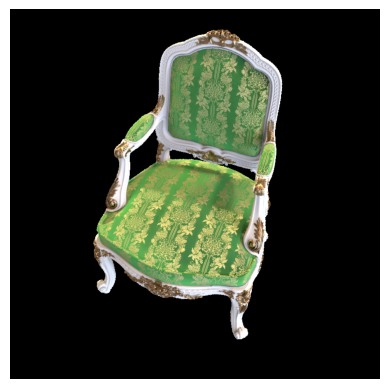

KeyboardInterrupt: 

In [11]:
if __name__ == "__main__":
    main_pipeline("data/nerf_synthetic/chair", "outdir")